In [1]:
import numpy as np
import pandas as pd

# loading MNIST dataset
MNIST dataset consist of many handwritten digits

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:
- A DESCR key describing the dataset
- A data key containing an array with one row per instance and one column per feature
- A target key containing an array with the labels

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto') # as_frame=True will return pandas dataframe
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- There are 70,000 images, and each image has 784 features.
- each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

In [3]:
X,y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


- the values in y is strings. We prefer numbers, so let’s cast y to integers

In [4]:
y = y.astype(np.uint8)

### display image

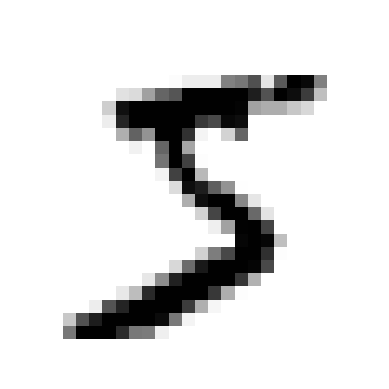

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

### split in train test set
MNIST dataset is already divided in train test and shuffeld

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classifier

## Stochastic Gradient Descent (SGD) Classifier
This clas‐ sifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning).

In [7]:
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits. 
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict([some_digit])

array([ True])

## Performance measure

Evaluating a classifier is often significantly trickier than evaluating a regressor

### Cross Validation

Accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

### Confusion Matrix

- The general idea is to count the number of times instances of class A are classified as class B.
- Each row in a confusion matrix represents an actual class, while each column repre‐ sents a predicted class. 
- For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.
- To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets.

#### Cross val predict
Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.

- While cross_val_predict does make multiple predictions during cross-validation, it returns a single array of aggregated predictions for each data point in your input dataset.
- Splits the data: It divides the dataset into folds (typically using KFold or StratifiedKFold).
- Iterates through folds:
  For each fold:
    - It trains the model on the remaining folds (excluding the current fold).
    - It makes predictions on the data points in the current fold, which are considered as a "test set" for that iteration.
- Aggregates predictions: After all folds are processed, it combines the individual predictions for each data point into a single array.
- Returns the aggregated prediction array: This array has the same length as your original input data, with each element representing the cross-validated prediction for the corresponding data point.

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) 
# returns numpy array
# default method="predict"
# other method: method="decision_function"

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

### Precision, Recall and F1 score

- TN = Element is incorrect and it is predicted as incorrect
- FP = False Positive = The element is incorrect but it is predicted as correct
- TP = True Positive = The element is correct and it is predicted as correct
- FN = False Negative = Element is correct but it is predicted as incorrect

                        Predicted
  
                      Negative   Positive
                    
                Negative  TN          FP        
    Actual

                Positive  FN          TP      

#### Precision
A more concise metric than confusion matrix is Precision
- accuracy of the positive pre‐ dictions is called the precision of the classifier

$$Precision = \frac{TP}{TP + FP}$$

#### Recall

is the ratio of positive instances that are correctly detected by the classifier.
- It is also called sensitivity or true positive rate (TPR)

$$Recall = \frac{TP}{TP + FN}$$

#### F1 Score
- The F1 score is the harmonic mean of precision and recall.
- Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.
- As a result, the classifier will only get a high F1 score if both recall and precision are high.

$$F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$$

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

### Precision - Recall Tradeoff

To understand this tradeoff, let’s look at how the SGDClassifier makes its classification decisions. 

- For each instance, it computes a score based on a decision function,
- and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class.
- The SGDClassifier uses a threshold equal to 0.
- Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want
- Raising the threshold decreases recall increases precision.
- Lowering the threshold increases the recall but decreses the precision.
  
  

In [ ]:
y_score = sgd_clf.decision_function([some_digit])
print("score: ",y_score)

threshold = 0
y_some_digit_pred = (y_score > threshold)
print("When threshold = 0 ",y_some_digit_pred)

threshold = 8000
y_some_digit_pred = (y_score > threshold) 
print("When threshold = 8000 ",y_some_digit_pred)

This confirms that raising the threshold decreases recall.

### Precision Recall Curve 

Now how do you decide which threshold to use? For this you will first need to get the scores of all instances in the training set using the cross_val_predict() function again, but this time specifying that you want it to return decision scores instead of predictions

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method="decision_function")

Now with these scores you can compute precision and recall for all possible thresholds using the precision_recall_curve() function.

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

- Iterates through thresholds: It examines a range of potential decision thresholds, typically starting from the highest score and gradually lowering it.
- Classifies predictions at each threshold: For each threshold, it classifies each prediction as TP, FP, TN, or FN based on the y_score and y_true.
- Calculates precision and recall: It computes precision (TP / (TP + FP)) and recall (TP / (TP + FN)) at that specific threshold.
- Collects values: It appends the precision and recall values obtained for each threshold to separate arrays.
- Returns arrays: It returns two arrays: one containing precision values for each threshold, and the other containing recall values for each threshold.


In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    plt.xlabel("Threshold")
    plt.ylabel("Blue: Precision, Green: Recall")

    plt.xlim([-30000, 30000])
    plt.ylim([0.0, 1.0])

    plt.grid(True)
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

#### Precision vs Recall curve
Another way to select a good precision/recall tradeoff is to plot precision directly against recall

In [ ]:
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall")
plt.plot(recalls, precisions, "b--", label="Precision") 
plt.grid(True)
plt.show()


- We can see precision starts to fall sharply after certian threshold
- You will probably want to select a precision/recall tradeoff just before that drop.
- the choice depends on your project.

So let’s suppose you decide to aim for 90% precision. You look up the first plot and find that you need to use a threshold of about 8,000. To be more precise you can search for the lowest threshold that gives you at least 90% precision (np.argmax() will give us the first index of the maximum value

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

To make predictions (on the training set for now), instead of calling the classifier’s
predict() method, you can just run this code

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Check the predictions's precision and recall value

In [ ]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

## receiver operating characteristic (ROC) curve
- common tool used with binary classifiers
- ROC curve plots the true positive rate (another name for recall) against the false positive rate.
- The FPR is the ratio of negative instances that are incorrectly classified as positive.
- It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative.
- The TNR is also called specificity.
- Hence the ROC curve plots sensitivity (recall) versus 1 – specificity.


In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--')

    # Add axes labels and title:
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    
plot_roc_curve(fpr, tpr)
plt.show()

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A per‐ fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

### what to use PR vs ROC

Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top- right corner).

# Conclusion for binary classification

Hopefully you now know how to train binary classifiers, choose the appropriate met‐ ric for your task, evaluate your classifiers using cross-validation, select the precision/ recall tradeoff that fits your needs, and compare various models using ROC curves and ROC AUC scores.


# Multi Class Classifiaction (multinomial classifiers)


